In [160]:
import base

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

from transformers import AddTime, LeadLag
from sigKer_fast import sig_kernel_Gram_matrix 

In [152]:
#mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [242]:
#Helper function that extract rolling windows of historical prices of size h and means of the next future f prices.
def GetWindow(x, h_window=30, f_window=10):

    # First window
    X = np.array(x.iloc[:h_window,]).reshape(1,-1)
   
    # Append next window
    for i in range(1,len(x)-h_window+1):
        x_i = np.array(x.iloc[i:i+h_window,]).reshape(1,-1)
        X = np.append(X, x_i, axis=0)
        
    # Cut the end that we can't use to predict future price
    rolling_window = (pd.DataFrame(X)).iloc[:-f_window,]
    return rolling_window

def GetNextMean(x, h_window=30, f_window=10):
    return pd.DataFrame((x.rolling(f_window).mean().iloc[h_window+f_window-1:,]))

In [306]:
def PlotResult(y_train, y_test, y_train_predict, y_test_predict, name):
    
    train_len = len(y_train)
    test_len = len(y_test)
        
    #Visualise
    plt.figure(figsize=(12, 5))
    plt.plot(y_train_predict,color='red')

    plt.plot(range(train_len, train_len+len(y_test)),
             y_test_predict,
             label='Predicted average price',
             color='red',linestyle = '--')

    plt.plot(np.array((y_train).append(y_test)),
             label='Actual average price',
             color='green')

    plt.axvspan(len(y_train), len(y_train)+len(y_test),
                alpha=0.3, color='lightgrey')

    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best")
    plt.title('Predicting the mean BTC price with {}'.format(name))

In [71]:
#data is from https://www.cryptodatadownload.com/
BTC_price = pd.read_csv('../data/gemini_BTCUSD_day.csv',header=1)
# BTC_price = pd.read_csv('../data/gemini_BTCUSD_2020_1min.csv',header=1)

In [72]:
#drop the first column and reverse order
BTC_price = BTC_price.iloc[1:,:]
BTC_price = BTC_price.iloc[::-1]
BTC_price['Date'] = pd.to_datetime(BTC_price['Date'])
BTC_price.set_index('Date', inplace=True)

In [206]:
#select duration
initial_date = '2017-10-01'
finish_date = '2018-02-01'
BTC_price_time = BTC_price[initial_date:finish_date]

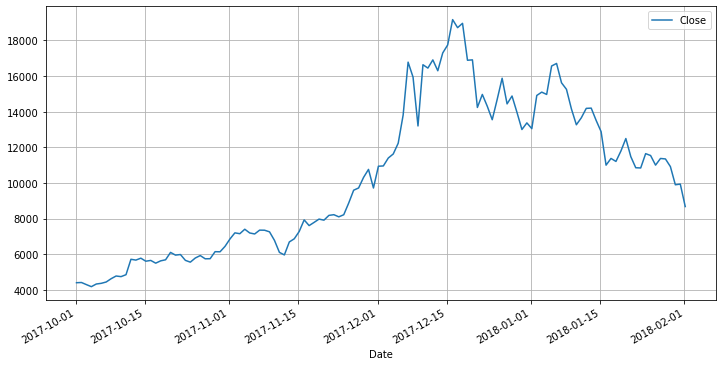

In [207]:
ax = BTC_price_time.plot(y= 'Close', figsize=(12,6), legend=True, grid=True, use_index=True)
plt.show()

In [284]:
# We use only close price
close_price = BTC_price_time.loc[:,'Close']
close_price = TimeSeriesScalerMinMax().fit_transform(close_price[None,:])
close_price = pd.DataFrame(np.squeeze(close_price))

In [285]:
h_window = 30
f_window = 10

In [286]:
# mean next price
y = GetNextMean(close_price, h_window = h_window , f_window = f_window)

In [287]:
# normal window features
X_window = GetWindow(close_price, h_window, f_window).values
# X_window = np.array(LeadLag().fit_transform(X_window))
X_window = np.array(AddTime().fit_transform(X_window))
# X_window = pd.DataFrame(X_window)

In [289]:
x_train, x_test, y_train, y_test = train_test_split(X_window, y, test_size=0.1, shuffle=False)

In [347]:
n, solver = 3, 0

In [348]:
gram_matrix = sig_kernel_Gram_matrix(x_train, x_train, n, solver, sym=True)

In [349]:
test_matrix = sig_kernel_Gram_matrix(x_train, x_test, n, solver, sym=False)

In [350]:
svr_parameters = {'C': np.logspace(0, 4, 5), 'gamma': np.logspace(-2, 2, 5)}

svr = SVR(kernel='precomputed')

svr_model = GridSearchCV(estimator=svr, 
                         param_grid=svr_parameters, 
                         cv=TimeSeriesSplit(n_splits=5),
                         n_jobs=-1)

In [351]:
svr_model.fit(gram_matrix, np.squeeze(y_train))

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=SVR(kernel='precomputed'), n_jobs=-1,
             param_grid={'C': array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
                         'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])})

In [352]:
#Make predictions
y_train_predict = svr_model.predict(gram_matrix.T)
y_test_predict = svr_model.predict(test_matrix.T)

In [353]:
#Calculate error
error_train = mean_absolute_error(y_train, y_train_predict)        
error_test = mean_absolute_error(y_test, y_test_predict)
p_error_train = mean_absolute_percentage_error(np.array(y_train).reshape(-1,1), np.array(y_train_predict).reshape(-1,1))
p_error_test = mean_absolute_percentage_error(np.array(y_test).reshape(-1,1), np.array(y_test_predict).reshape(-1,1))

print('mae_train:{0:.3f} = {1:.3f}%\n'.format(error_train, p_error_train))
print('mae_test:{0:.3f} = {1:.3f}%'.format(error_test, p_error_test))

mae_train:0.153 = 47.458%

mae_test:0.117 = 24.299%


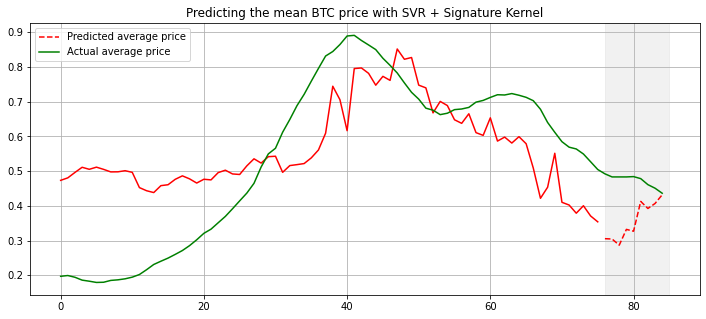

In [354]:
PlotResult(y_train, y_test, y_train_predict, y_test_predict, 'SVR + Signature Kernel')

In [309]:
kr_parameters = {'alpha': np.logspace(0, 4, 5), 'gamma': np.logspace(-2, 2, 5)}

kr = KernelRidge(kernel='precomputed')

kr_model = GridSearchCV(estimator=kr, 
                        param_grid=kr_parameters, 
                        cv=TimeSeriesSplit(n_splits=5),
                        n_jobs=-1)

In [310]:
kr_model.fit(gram_matrix, np.squeeze(y_train))

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=KernelRidge(kernel='precomputed'), n_jobs=-1,
             param_grid={'alpha': array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
                         'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])})

In [312]:
#Make predictions
y_train_predict = kr_model.predict(gram_matrix.T)
y_test_predict = kr_model.predict(test_matrix.T)

In [313]:
#Calculate error
error_train = mean_absolute_error(y_train, y_train_predict)        
error_test = mean_absolute_error(y_test, y_test_predict)
p_error_train = mean_absolute_percentage_error(np.array(y_train).reshape(-1,1), np.array(y_train_predict).reshape(-1,1))
p_error_test = mean_absolute_percentage_error(np.array(y_test).reshape(-1,1), np.array(y_test_predict).reshape(-1,1))

print('mae_train:{0:.3f} = {1:.3f}%\n'.format(error_train, p_error_train))
print('mae_test:{0:.3f} = {1:.3f}%'.format(error_test, p_error_test))

mae_train:0.186 = 51.440%

mae_test:0.104 = 21.628%


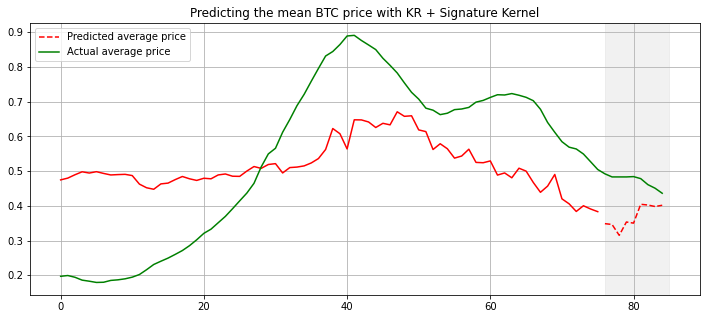

In [314]:
PlotResult(y_train, y_test, y_train_predict, y_test_predict, 'KR + Signature Kernel')